# Load dataset for EDA
This cell loads the generated UPI transactions CSV and shows basic dataset info (shape, columns, head).

In [33]:
import pandas as pd
from pathlib import Path

path = Path('..') / 'data' / 'synthetic' / 'upi_transactions_2020_2025.csv'

try:
    df = pd.read_csv(path, parse_dates=['timestamp'])
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset not found at {path.resolve()}. Run the generator script first.")

print('Dataset path:', path.resolve())
print('Shape:', df.shape)
print('Columns:', list(df.columns))

df.head()

Dataset path: A:\Projects\ai_digital_payment_failure_predictor\data\synthetic\upi_transactions_2020_2025.csv
Shape: (200000, 14)
Columns: ['transaction_id', 'timestamp', 'year', 'month', 'hour', 'day_of_week', 'amount', 'bank_name', 'network_latency_ms', 'device_type', 'retry_count', 'bank_load_score', 'past_user_failure_rate', 'failure_flag']


,transaction_id,timestamp,year,month,hour,day_of_week,amount,bank_name,network_latency_ms,device_type,retry_count,bank_load_score,past_user_failure_rate,failure_flag
0,f71636ba-8287-47e8-b87d-e03b6b969724,2024-08-23 10:12:49,2024,8,10,4,29.96,HDFC,466,desktop,0,0.328,0.0532,0
1,5ba45ab0-c039-4f35-969d-d92f9e199a1a,2022-08-19 10:23:21,2022,8,10,4,251.19,Kotak,912,mobile,0,0.722,0.0180,0
2,ed118568-e9bb-4220-b1cf-ea561560452d,2025-02-25 20:25:44,2025,2,20,1,1.80,SBI,289,desktop,0,0.126,0.0329,0
3,3e23f760-e837-4b73-8cf3-ad925842e0af,2024-03-08 15:53:03,2024,3,15,4,7.43,SBI,366,desktop,0,0.279,0.0206,0
4,c5b735b3-d9db-47a0-b766-a4b159b3532d,2020-07-25 19:03:38,2020,7,19,5,43.12,ICICI,756,mobile,2,0.673,0.0261,0


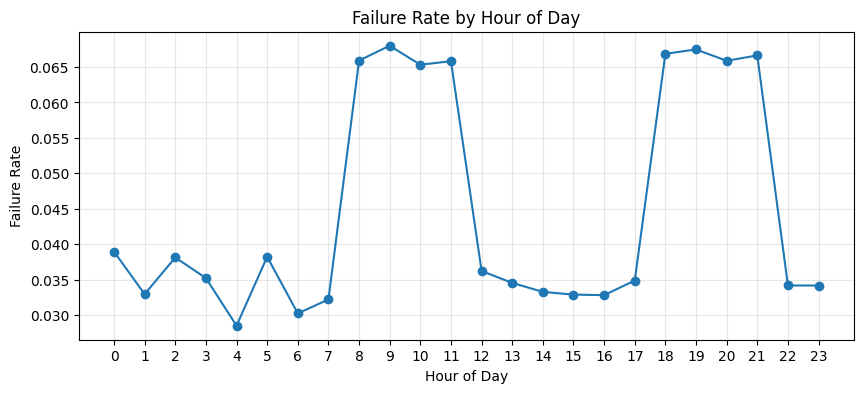

In [34]:
# Analyze failure rate by hour of day and plot a simple line chart
# Group by `hour` and compute mean of `failure_flag`
hourly_failure = df.groupby("hour")["failure_flag"].mean().reset_index()

# Plot (matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(hourly_failure["hour"], hourly_failure["failure_flag"], marker="o")
plt.xticks(range(0, 24))
plt.xlabel("Hour of Day")
plt.ylabel("Failure Rate")
plt.title("Failure Rate by Hour of Day")
plt.grid(alpha=0.3)
plt.show()

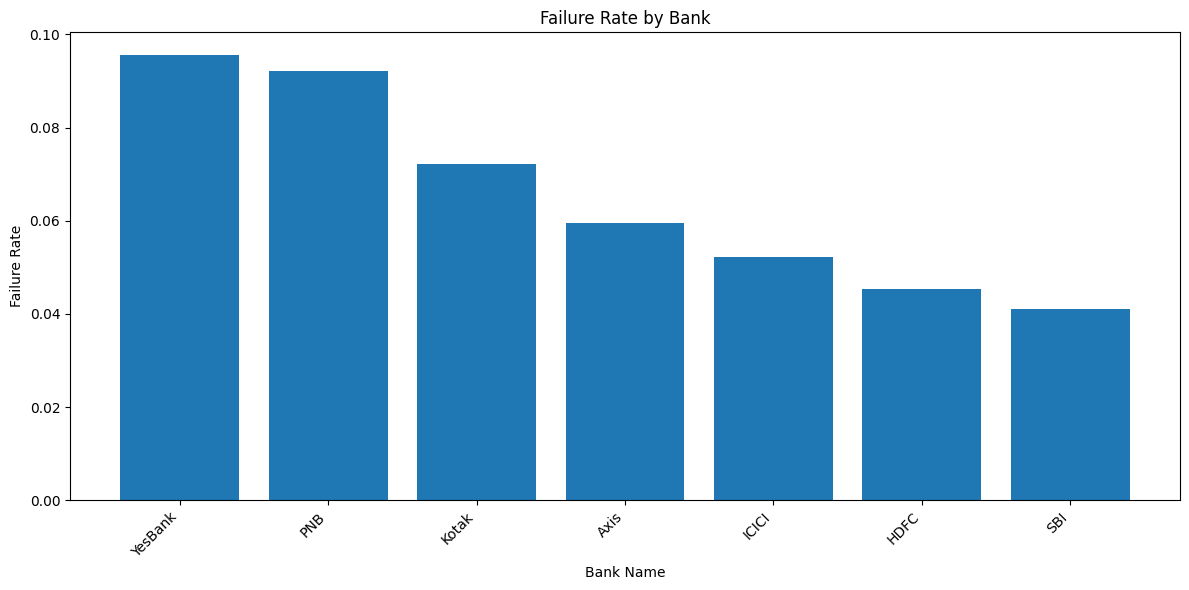

In [35]:
# Analyze failure rate by bank
# Group by `bank_name`, compute mean of `failure_flag`, sort descending, and plot
bank_failure = (
    df.groupby("bank_name")["failure_flag"].mean()
    .reset_index()
    .sort_values("failure_flag", ascending=False)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(bank_failure["bank_name"], bank_failure["failure_flag"], color="C0")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Bank Name")
plt.ylabel("Failure Rate")
plt.title("Failure Rate by Bank")
plt.ylim(0, bank_failure["failure_flag"].max() * 1.05)
plt.tight_layout()
plt.show()

**Observations**

- Failure rates vary substantially across banks; a small number of banks have notably higher failure rates than the rest, which may indicate bank-specific processing or routing issues.
- These banks should be investigated further (by merchant mix, transaction type, or time-of-day) to identify root causes.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_28020\311718840.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("latency_bin")["failure_flag"].mean().reset_index()


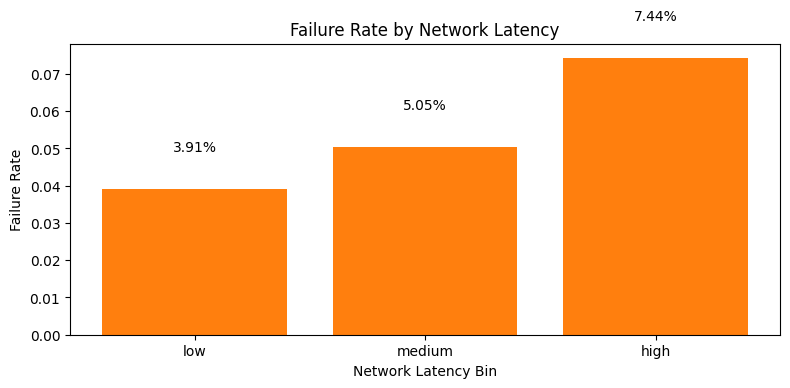

In [36]:
# Analyze failure rate by network latency
# Create latency bins (low/medium/high) using tertiles and compute mean failure rate
latency_labels = ["low", "medium", "high"]

# Use qcut to create roughly equal-sized bins; handle duplicates if values are identical
df["latency_bin"] = pd.qcut(df["network_latency_ms"], q=3, labels=latency_labels, duplicates="drop")

latency_failure = (
    df.groupby("latency_bin")["failure_flag"].mean().reset_index()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(latency_failure["latency_bin"].astype(str), latency_failure["failure_flag"], color="C1")
plt.xlabel("Network Latency Bin")
plt.ylabel("Failure Rate")
plt.title("Failure Rate by Network Latency")
plt.ylim(0, latency_failure["failure_flag"].max() * 1.05)
for i, v in enumerate(latency_failure["failure_flag"]):
    plt.text(i, v + 0.01, f"{v:.2%}", ha="center")
plt.tight_layout()
plt.show()

**Observations**

- Transactions in the **high** latency bin show higher failure rates compared with the **low** and **medium** bins, suggesting network delays increase failure probability.
- Investigating by transaction type or time-of-day could help confirm whether latency is a direct cause or correlated with other factors.

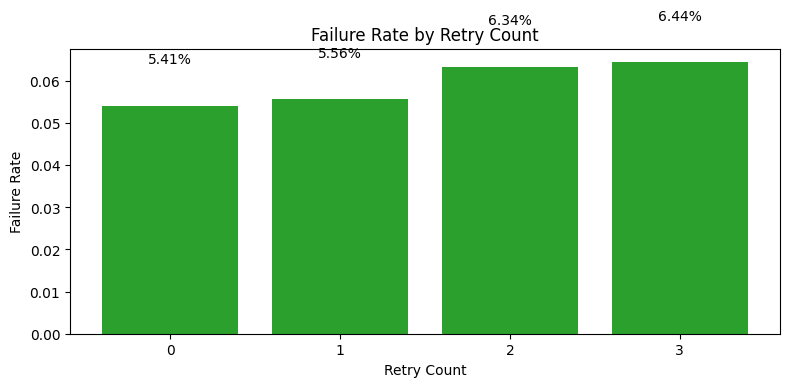

In [37]:
# Analyze failure rate by retry count
# Group by `retry_count`, compute mean failure rate, and plot
retry_failure = (
    df.groupby("retry_count")["failure_flag"]
    .mean()
    .reset_index()
    .sort_values("retry_count")
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(retry_failure["retry_count"].astype(str), retry_failure["failure_flag"], color="C2")
plt.xlabel("Retry Count")
plt.ylabel("Failure Rate")
plt.title("Failure Rate by Retry Count")
plt.ylim(0, retry_failure["failure_flag"].max() * 1.05)
for i, v in enumerate(retry_failure["failure_flag"]):
    plt.text(i, v + 0.01, f"{v:.2%}", ha="center")
plt.tight_layout()
plt.show()

**Observations**

- Failure rate tends to increase with higher retry counts, suggesting that transactions with more retries are more likely to ultimately fail.
- Investigating the root causes of repeated retries (e.g., network issues, issuer declines) could help reduce overall failure rates.

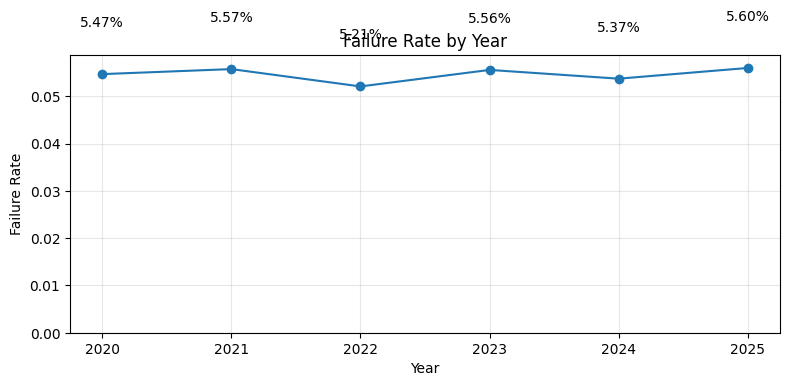

In [38]:
# Analyze failure rate by year
# Ensure `year` column exists, then group by `year` and compute mean failure rate
if "year" not in df.columns:
    df["year"] = df["timestamp"].dt.year

yearly_failure = (
    df.groupby("year")["failure_flag"].mean().reset_index().sort_values("year")
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(yearly_failure["year"], yearly_failure["failure_flag"], marker="o", linestyle="-")
plt.xlabel("Year")
plt.ylabel("Failure Rate")
plt.title("Failure Rate by Year")
plt.ylim(0, yearly_failure["failure_flag"].max() * 1.05)
plt.grid(alpha=0.3)
plt.xticks(yearly_failure["year"])
for x, y in zip(yearly_failure["year"], yearly_failure["failure_flag"]):
    plt.text(x, y + 0.01, f"{y:.2%}", ha="center")
plt.tight_layout()
plt.show()

**Observations**

- Failure rates change across years; check whether there's a consistent upward or downward trend and investigate any years with large deviations.
- Correlating year-level changes with major system, policy, or volume shifts can help identify root causes.

In [39]:
# Prepare features for modeling
# Select relevant input features and keep `failure_flag` as target
features = [
    "amount", "hour", "day_of_week", "bank_name", "network_latency_ms",
    "device_type", "retry_count", "bank_load_score", "past_user_failure_rate",
]

# Check required columns exist
missing = [c for c in features + ["failure_flag"] if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns for feature preparation: {missing}")

X = df[features].copy()

# One-hot encode categorical columns (do not scale)
X = pd.get_dummies(X, columns=["bank_name", "device_type"], dummy_na=False)

y = df["failure_flag"].copy()

print("Feature matrix shape:", X.shape)
print("Target distribution (counts):")
print(y.value_counts())
print("\nTarget distribution (percent):")
print(y.value_counts(normalize=True).apply(lambda v: f"{v:.2%}"))

Feature matrix shape: (200000, 17)
Target distribution (counts):
failure_flag
0    189073
1     10927
Name: count, dtype: int64

Target distribution (percent):
failure_flag
0    94.54%
1     5.46%
Name: proportion, dtype: object


In [40]:
# Split prepared data into training and validation sets
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    raise ImportError("scikit-learn is required for train_test_split. Install scikit-learn to proceed.")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

print("\nFailure rate (train):", f"{y_train.mean():.2%}")
print("Failure rate (val):", f"{y_val.mean():.2%}")

# Also show counts to confirm stratified sampling
print("\nTarget counts (train):")
print(y_train.value_counts())
print("\nTarget counts (val):")
print(y_val.value_counts())

X_train shape: (160000, 17)
X_val shape: (40000, 17)
y_train shape: (160000,)
y_val shape: (40000,)

Failure rate (train): 5.46%
Failure rate (val): 5.46%

Target counts (train):
failure_flag
0    151258
1      8742
Name: count, dtype: int64

Target counts (val):
failure_flag
0    37815
1     2185
Name: count, dtype: int64


In [41]:
# Baseline Logistic Regression model
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, confusion_matrix, recall_score
except ImportError:
    raise ImportError("scikit-learn is required to train and evaluate the model. Install scikit-learn to proceed.")

model = LogisticRegression(class_weight="balanced", random_state=42, solver="liblinear", max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print("Classification report (validation):")
print(classification_report(y_val, y_pred, digits=4))

print("Confusion matrix (validation):")
print(confusion_matrix(y_val, y_pred))

# Emphasize recall for the failure class (1)
recall_failure = recall_score(y_val, y_pred, pos_label=1)
print(f"\nRecall for failure class (1): {recall_failure:.4f}")

Classification report (validation):
              precision    recall  f1-score   support

           0     0.9589    0.6249    0.7567     37815
           1     0.0764    0.5368    0.1337      2185

    accuracy                         0.6201     40000
   macro avg     0.5177    0.5809    0.4452     40000
weighted avg     0.9107    0.6201    0.7227     40000

Confusion matrix (validation):
[[23632 14183]
 [ 1012  1173]]

Recall for failure class (1): 0.5368


In [42]:
# Explain Logistic Regression model coefficients
import pandas as pd
from IPython.display import display

# Ensure model and training data exist
if "model" not in globals():
    raise NameError("Trained model `model` not found. Run the training cell first.")

if not hasattr(model, "coef_"):
    raise AttributeError("The provided model does not expose coefficients (model.coef_).")

coefs = model.coef_.ravel()
feature_names = X_train.columns
if len(coefs) != len(feature_names):
    raise ValueError("Number of model coefficients does not match number of features.")

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df["effect"] = coef_df["coefficient"].apply(
    lambda x: "increases failure" if x > 0 else ("decreases failure" if x < 0 else "neutral")
)
coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

print("Top features by absolute coefficient value:")
display(coef_df.head(20))

Top features by absolute coefficient value:


,feature,coefficient,abs_coef,effect
0,past_user_failure_rate,0.712746,0.712746,increases failure
1,bank_load_score,0.614870,0.614870,increases failure
2,bank_name_SBI,-0.214806,0.214806,decreases failure
3,device_type_mobile,-0.212282,0.212282,decreases failure
4,device_type_desktop,-0.203776,0.203776,decreases failure
5,bank_name_HDFC,-0.176712,0.176712,decreases failure
6,device_type_pos,-0.169737,0.169737,decreases failure
7,bank_name_ICICI,-0.154178,0.154178,decreases failure
8,bank_name_Axis,-0.133548,0.133548,decreases failure
9,bank_name_PNB,0.113101,0.113101,increases failure


**Summary**

- Positive coefficients (listed above) **increase** the probability of payment failure; negative coefficients **decrease** it.
- Focus on the top features with large positive coefficients to prioritize interventions that reduce failures.

In [43]:
# Reusable prediction function
from typing import Dict

def predict_payment_failure(input_dict: Dict) -> Dict:
    """Predict payment failure probability and risk label for a single input.

    Args:
        input_dict: Mapping with keys:
            amount, hour, day_of_week, bank_name, network_latency_ms,
            device_type, retry_count, bank_load_score, past_user_failure_rate

    Returns:
        dict with keys: 'failure_probability' (float) and 'failure_risk_label' (str: Low/Medium/High)

    Notes:
        - Uses the trained `model` from this notebook and the same one-hot encoding as training.
        - Raises if required inputs are missing or if `model` is not available.
    """
    import pandas as pd
    import numpy as np

    # Ensure trained model and feature columns exist
    if "model" not in globals():
        raise NameError("Trained model `model` not found. Run the training cell first.")

    # Base feature names required in the input
    base_features = [
        "amount", "hour", "day_of_week", "bank_name", "network_latency_ms",
        "device_type", "retry_count", "bank_load_score", "past_user_failure_rate",
    ]

    missing = [f for f in base_features if f not in input_dict]
    if missing:
        raise KeyError(f"Missing required input features: {missing}")

    # Build dataframe for a single sample and keep base order
    df_in = pd.DataFrame([input_dict])[base_features].copy()

    # One-hot encode categorical variables the same way as training
    df_in = pd.get_dummies(df_in, columns=["bank_name", "device_type"], dummy_na=False)

    # Align input columns to the model's training columns
    model_cols = list(X_train.columns) if "X_train" in globals() else list(X.columns)

    # Add any missing model columns with zeros
    for col in model_cols:
        if col not in df_in.columns:
            df_in[col] = 0

    # Drop any unexpected extra columns that were not present during training
    extra_cols = [c for c in df_in.columns if c not in model_cols]
    if extra_cols:
        df_in = df_in.drop(columns=extra_cols)

    # Reorder columns to match the model
    df_in = df_in[model_cols]

    # Ensure numeric dtype
    df_in = df_in.astype(float)

    # Predict probability
    prob = float(model.predict_proba(df_in)[:, 1][0])

    # Risk labeling
    if prob < 0.3:
        label = "Low"
    elif prob <= 0.6:
        label = "Medium"
    else:
        label = "High"

    return {"failure_probability": prob, "failure_risk_label": label}

# Example usage (uncomment to run):
example = {
     "amount": 250.0,
     "hour": 14,
     "day_of_week": 2,
     "bank_name": "Bank A",
     "network_latency_ms": 120,
     "device_type": "mobile",
     "retry_count": 1,
     "bank_load_score": 0.6,
     "past_user_failure_rate": 0.02,
}
print(predict_payment_failure(example))

{'failure_probability': 0.48722048941911744, 'failure_risk_label': 'Medium'}


**Prediction function summary**

- `predict_payment_failure(input_dict)` converts a single input dict into the same feature format used for training, applies the trained `model`, returns a numeric `failure_probability` and a `failure_risk_label` (Low / Medium / High) based on the specified thresholds.
- Raises clear errors if required inputs or the trained model are missing.

In [44]:
# Persist trained model and feature columns
from pathlib import Path
import json

models_dir = Path('..') / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

try:
    import joblib
except Exception:
    raise ImportError("joblib is required to serialize the model. Install it with `pip install joblib`.")

# Ensure a trained model is present
if 'model' not in globals():
    raise NameError("Trained model `model` not found. Run the training cell before saving the model.")

# Determine feature columns used during training
if 'X_train' in globals():
    feature_cols = list(X_train.columns)
elif 'X' in globals():
    feature_cols = list(X.columns)
elif hasattr(model, 'feature_names_in_'):
    feature_cols = list(model.feature_names_in_)
else:
    feature_cols = None

# Save model
model_path = models_dir / 'model.joblib'
joblib.dump(model, model_path)
print(f"Saved model to: {model_path.resolve()}")

# Save feature columns if available
if feature_cols is not None:
    feat_path = models_dir / 'feature_columns.json'
    with open(feat_path, 'w') as f:
        json.dump(feature_cols, f)
    print(f"Saved feature columns to: {feat_path.resolve()}")
else:
    print("Feature columns not determined; `feature_columns.json` not written.")

Saved model to: A:\Projects\ai_digital_payment_failure_predictor\models\model.joblib
Saved feature columns to: A:\Projects\ai_digital_payment_failure_predictor\models\feature_columns.json
